In [2]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0


env: CUDA_VISIBLE_DEVICES=0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn


In [4]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [5]:
from utils import data_utils

data = data_utils.GAS()

dim = data.n_dims
num_layers = 5


In [6]:
X_train_tensor = torch.from_numpy(data.trn.x)
X_test_tensor = torch.from_numpy(data.tst.x)

In [7]:
def init_weights(m):
    if 'Linear' in str(type(m)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [8]:
from torch.distributions import MultivariateNormal

prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                           torch.eye(data.n_dims).to(device))


In [9]:
from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, MAF
from src.mrartemev_nflib.nn import ARMLP

flows = []
for _ in range(num_layers):
    flows.append(MAF(dim=data.n_dims, base_network=ARMLP))
    flows.append(InvertiblePermutation(dim=data.n_dims))
model = NormalizingFlowModel(prior, flows).apply(init_weights).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

dloader = DataLoader(TensorDataset(X_train_tensor), batch_size=2**14,
                     shuffle=True, drop_last=True, num_workers=4)
test_dloader = DataLoader(TensorDataset(X_test_tensor), batch_size=2**14,
                          shuffle=True, drop_last=True, num_workers=4)


In [11]:
from IPython.display import clear_output
from tqdm import tqdm


epoches = 50000
plot_freq = 20

epoch_losses = []
train_losses = []

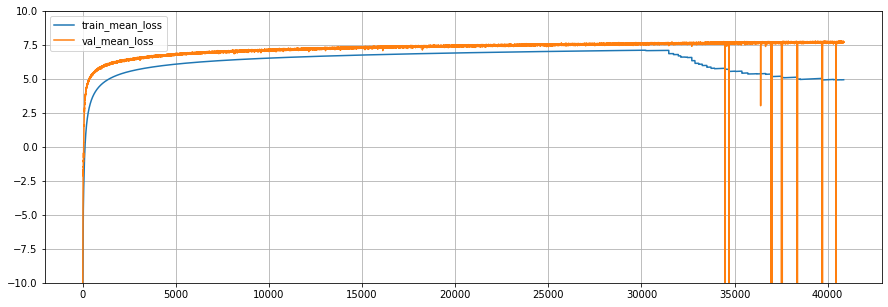

 82%|████████▏ | 40873/50000 [32:49:18<7:19:44,  2.89s/it]


KeyboardInterrupt: 

In [11]:
for epoch in tqdm(range(epoches), position=0):
    for ind, batch in enumerate(dloader):
        model.train()
        
        # fit
        optimizer.zero_grad()
        logp_x = model.log_prob(batch[0].to(device))
        if torch.isnan(logp_x).sum() > 0:
            print(epoch, ind, 'contaminated')
#         logp_x = logp_x[~torch.isnan(logp_x)]
        loss = -torch.mean(logp_x)
        loss.backward()
        
        # clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                
        # step
        optimizer.step()

        # log
        train_losses.append(-loss.item())
        
    with torch.no_grad():
        model.eval()
        logp_x = torch.mean(model.log_prob(next(iter(test_dloader))[0].to(device))).item()
        epoch_losses.append([np.mean(train_losses), logp_x])
    
    if epoch % plot_freq == 0 and epoch != 0:
        clear_output(True)
        plt.figure(figsize=(15, 5))
        val_losses = np.array(epoch_losses)
        plt.plot(val_losses[:, 0], label='train_mean_loss')
        plt.plot(val_losses[:, 1], label='val_mean_loss')
        plt.ylim(-10, 10)
        plt.grid()
        plt.legend()
        plt.show()
        

In [12]:
torch.save(model.state_dict(), '../models/MAF5_50k.state_dict')
torch.save(optimizer.state_dict(), '../models/optimizer_MAF5_50k.state_dict')

In [14]:
model.load_state_dict(torch.load('../models/MAF5_50k.state_dict'))

<All keys matched successfully>

In [15]:
model.cpu()
model.prior = MultivariateNormal(torch.zeros(data.n_dims),
                                 torch.eye(data.n_dims))
torch.mean(model.log_prob(X_train_tensor)).item()

-11081682518016.0

In [16]:
model.cpu()
model.prior = MultivariateNormal(torch.zeros(data.n_dims),
                                 torch.eye(data.n_dims))
torch.mean(model.log_prob(X_test_tensor)).item()

-17195048370176.0

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf, make_clf_dataset


In [19]:
model.sample_n = lambda x: model.sample(x)
model.eval()
pass

In [ ]:
clf_ds_train = make_clf_dataset(X_train_tensor, model)
clf_ds_test = make_clf_dataset(X_test_tensor, model)

In [ ]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=1,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

In [ ]:
calibrated_model = CalibratedModel(clf, model, logit=True)

In [ ]:
-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor)

In [ ]:
clf2000 = CatBoostClassifier(
    2000, eval_metric='AUC',
    metric_period=100,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

calibrated_model2000 = CalibratedModel(clf2000, model, logit=True)

-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model2000, X_test_tensor)